In [3]:
import matplotlib.pyplot as plt
import numpy as np

from qutip import * 
import os

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
    'text.usetex': True,              # Enable LaTeX for text rendering
    'font.family': 'serif',           # Use a serif font family
    'font.serif': 'Palatino',         # Set Palatino as the serif font
    'text.latex.preamble': r'\usepackage{amsmath}',
    'font.size': 20,                   # Font size for general text
    'axes.titlesize': 20,              # Font size for axis titles
    'axes.labelsize': 20,              # Font size for axis labels
    'xtick.labelsize': 20,             # Font size for x-axis tick labels
    'ytick.labelsize': 20,             # Font size for y-axis tick labels
    'legend.fontsize': 20,             # Font size for legends
    'figure.figsize': [8, 6],          # Size of the plot (width x height)
    'figure.autolayout': True,         # Automatic layout adjustment
    'savefig.format': 'svg',           # Default format for saving figures
    'figure.facecolor': 'none',        # Make the figure face color transparent
    'axes.facecolor': 'none',          # Make the axes face color transparent
    'savefig.transparent': True        # Save figures with transparent background
})

output_dir = r"C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_9\Master_thesis\Figures_From_Python"
os.makedirs(output_dir, exist_ok=True)

$$
\displaystyle H = \sum_{n=1}^N \left[ \frac{\omega_0}{2} \sigma_z^{(n)} + \omega \sigma_x^{(n)} \right] 
- J_{ff} \sum_{\text{nearest neighbors}} \sigma_+^{(n)} \sigma_-^{(n+1)}.
$$

In [2]:
# Set the system parameters
N       = 3      # number of atoms
n_chains = 1     # number of chains
omega_0 = 1.     # Energy splitting of every atom
omega   = 1.     # driving
J_flipflop = 0.  # Flip-flop interaction of (neighboring) spins
nbar = 1         # average photon (excitation) number

# collective decay and dephasing
gamma_decay_collective = 0.1 * nbar
gamma_dephase_collective = 0.1

# initial state
psiini = basis(N,0)

In [3]:
# Setup N-Qubit operators
sm_list, sp_list, sz_list = [], [], []
for i in range(N):
    op = np.zeros((N,N))
    op[0, i] = 1
    sp_list.append(Qobj(op))
    sm_list.append(Qobj(op.T))
    sz_list.append((sp_list[i] * sm_list[i] - sm_list[i] * sp_list[i]))

In [4]:
# define the Hamiltonian
def hamiltonian(omega, omega_0, N, n_chains):
    H = 0

    # Add energy splitting terms (diagonal in h)
    for i in range(N):
        H -= 0.5 * omega_0 * sz_list[i] + omega * (sp_list[i] - sm_list[i]) 

    for i in range(N):
        for j in range(N):
            H -= 1 * (sp_list[i] * sm_list[j])     # Add flip-flop interaction terms
    return H

H = hamiltonian(omega, omega_0, N, n_chains)

$$
C_{\text{decay}} = \sqrt{\gamma} \sum_{n=1}^N \sigma_-^{(n)}
$$
$$
C_{\text{dephase}} = \sqrt{\gamma} \sum_{n=1}^N \sigma_z^{(n)}
$$


In [5]:
# Define the collective collapse operators
c_ops_decay   = [np.sqrt(gamma_decay_collective)   * sum(sm_list[i] for i in range(N))]
c_ops_dephase = [np.sqrt(gamma_dephase_collective) * sum(sz_list[i] for i in range(N))]

# Combine dephasing and decay
c_ops = c_ops_decay + c_ops_dephase 

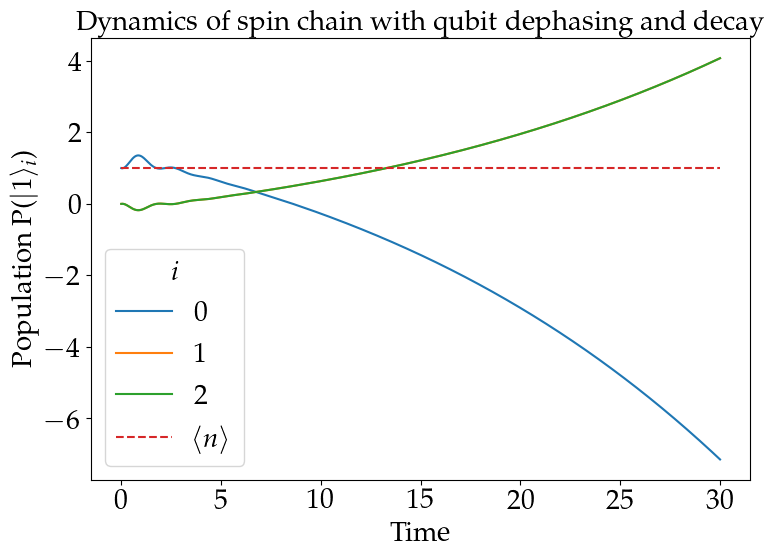

In [6]:
times = np.linspace(0, 30, 1000) # list of times
# Projection operators for each spin onto the upper state |1>
projector_upper = [basis(N, i) * basis(N, i).dag() for i in range(N)]
excitation_operator = qeye(N)  # \sum_i sigma_-^i * sigma_+^i

# evolution
result = mesolve(H, psiini, times, c_ops, projector_upper + [excitation_operator], options={"store_states": True})
# Plot the population of the upper state for each spin
for i in range(N):
    plt.plot(times, result.expect[i], label=fr"${i}$", linestyle='-')  # Solid line
plt.plot(times, result.expect[N],label=r"$\langle n \rangle$", linestyle='--')

plt.legend(title="$i$")
plt.xlabel("Time")
plt.ylabel(r"Population P($|1\rangle_i$)")
plt.title("Dynamics of spin chain with qubit dephasing and decay")
plt.show()

$$$\( \hat{N} = \sum_{i=1}^{N} \frac{1}{2} (\hat{\sigma}_z^{(i)} + 1) \)$$

In [7]:
N_op = 0.5 * (qeye(N) * N +  sum(sm_list[i] for i in range(N)))

In [8]:
N_op

Quantum object: dims=[[3], [3]], shape=(3, 3), type='oper', dtype=Dense, isherm=False
Qobj data =
[[2.  0.  0. ]
 [0.5 1.5 0. ]
 [0.5 0.  1.5]]

In [5]:
# Single Excitation Subspace using QuTiP

## Introduction
"""
The single excitation subspace is a reduced Hilbert space for systems where the total number of excitations
is restricted to one. This is common in quantum optics and many-body systems where excitations are conserved.

In this notebook, we will:
1. Create a multi-qubit system using QuTiP.
2. Project the full Hilbert space to the single excitation subspace.
3. Analyze operators and dynamics in this subspace.
"""

# Import necessary libraries
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

## Define the System
"""
Consider a two-qubit system, where each qubit can either be in the ground state |g⟩ or excited state |e⟩.
The full Hilbert space for this system has dimensions 2^2 = 4:
    {|gg⟩, |ge⟩, |eg⟩, |ee⟩}.
The single excitation subspace is spanned by {|ge⟩, |eg⟩}.
"""

# Number of qubits
N = 2

# Basis states for the full Hilbert space
basis_states = [basis(2, 0), basis(2, 1)]  # |0⟩ and |1⟩


# Create all possible combinations of basis states for N qubits
full_basis = [tensor(*states) for states in product(basis_states, repeat=N)]

print("Full Hilbert space basis states:")
for i, state in enumerate(full_basis):
    print(f"State {i}: {state}")
print("Full Hilbert space basis states:")
for i, state in enumerate(full_basis):
    print(f"State {i}: {state}")

## Projecting to the Single Excitation Subspace
"""
The single excitation subspace contains states where exactly one qubit is excited.
For a two-qubit system, this is spanned by:
    {|ge⟩, |eg⟩}.
"""

# Single excitation basis
single_excitation_basis = [tensor(basis(2, 0), basis(2, 1)), tensor(basis(2, 1), basis(2, 0))]

print("\nSingle excitation subspace basis states:")
for state in single_excitation_basis:
    print(state)

## Operators in the Single Excitation Subspace
"""
Operators in the full Hilbert space must be projected to the single excitation subspace.

For example, the Pauli-Z operator for each qubit in the single excitation subspace can be represented as:
"""

# Pauli-Z operator on the first qubit
sigma_z_full = tensor(sigmaz(), qeye(2))
sigma_z_proj = qeye(2).proj(single_excitation_basis) * sigma_z_full

print("\nPauli-Z operator in the single excitation subspace:")
print(sigma_z_proj)

## Dynamics in the Single Excitation Subspace
"""
Let us define a simple Hamiltonian in the single excitation subspace to illustrate dynamics.
We consider a symmetric coupling between the qubits.
"""

# Hamiltonian in the single excitation subspace
J = 1.0  # Coupling strength
H = J * (tensor(basis(2, 0), basis(2, 1)).dag() * tensor(basis(2, 1), basis(2, 0)) +
         tensor(basis(2, 1), basis(2, 0)).dag() * tensor(basis(2, 0), basis(2, 1)))

print("\nHamiltonian in the single excitation subspace:")
print(H)

# Initial state: qubit 1 excited
psi0 = tensor(basis(2, 1), basis(2, 0))

# Time evolution
times = np.linspace(0, 10, 100)
result = mesolve(H, psi0, times, [], [])

## Plotting the Dynamics
plt.figure()
plt.plot(times, [expect(op, state) for state in result.states])
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('Dynamics in Single Excitation Subspace')
plt.show()

NameError: name 'product' is not defined

In [49]:
# base 2 lvl atom
psi0 = basis(2, 0)  # Vector |0>
psi1 = basis(2, 1)  # Vector |1>
# Set the system parameters
N = 50  # number of atoms
n_chains = 1  # number of chains
omega_0 = 1.  # Energy splitting of every atom
omega = 1.  # driving
J_flipflop = 1.  # Flip-flop interaction of (neighboring) spins
nbar = 1  # average photon (excitation) number

# collective decay and dephasing
gamma_decay_collective = 0.1 * nbar
gamma_dephase_collective = 0.1

# initial state
state_list = [psi1] + [psi0] * (N - 1)
psiini = tensor(state_list)  # Vector |100...>
# Setup N-Qubit operators
sx_list, sy_list, sz_list, sm_list, sp_list = [], [], [], [], []
for i in range(N):
    op_list = [qeye(2)] * N
    op_list[i] = sigmax()
    sx_list.append(tensor(op_list))
    op_list[i] = sigmay()
    sy_list.append(tensor(op_list))
    op_list[i] = sigmaz()
    sz_list.append(tensor(op_list))
    op_list[i] = sigmam()
    sm_list.append(tensor(op_list))
    op_list[i] = sigmap()
    sp_list.append(tensor(op_list))

MemoryError: Unable to allocate 32.0 GiB for an array with shape (1073741824, 2, 1, 1) and data type complex128